In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
train_data_dir = '/content/drive/MyDrive/Kaggle3/Train_Alphabet/'
test_data_dir = '/content/drive/MyDrive/Kaggle3/Test_Alphabet/'

# Step 2: Define function to load and preprocess images
def load_and_preprocess_images(data_dir):
    images = []
    labels = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for filename in os.listdir(label_dir):
                if filename.endswith('.png'):
                    image_path = os.path.join(label_dir, filename)
                    # Check if the image is loaded successfully
                    image = cv2.imread(image_path)
                    if image is not None:  # Ensure image is not empty
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
                        image = cv2.resize(image, (224, 224))  # Resize image to (224, 224)
                        images.append(image)
                        labels.append(label)
                    else:
                        print(f"Warning: Unable to load image '{image_path}'")
    return np.array(images), np.array(labels)

In [5]:
# Step 3: Load and preprocess training and testing images
X_train, y_train = load_and_preprocess_images(train_data_dir)
X_test, y_test = load_and_preprocess_images(test_data_dir)

In [ ]:
np.save('X_train1_vgg.npy', X_train)
np.save('y_train1_vgg.npy', y_train)
np.save('X_test1_vgg.npy', X_test)
np.save('y_test1_vgg.npy', y_test)

In [ ]:
X_train = np.load('X_train1_vgg.npy')
y_train = np.load('y_train1_vgg.npy')
X_test = np.load('X_test1_vgg.npy')
y_test = np.load('y_test1_vgg.npy')

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Step 4: Load the pre-trained VGG19 model with the top layers included
base_model = VGG19(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

In [ ]:
# Step 5: Compile the model
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('vgg19_asl_model2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
import pickle
# Step 6: Train the model
history = base_model.fit(preprocess_input(X_train), y_train_encoded, epochs=15, batch_size=32, validation_data=(preprocess_input(X_test), y_test_encoded), callbacks=[checkpoint])
# Save the training history
with open('vgg19_training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
import pickle
with open('/content/drive/MyDrive/Kaggle3/training_history.pkl', 'rb') as f:
    history = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Kaggle3/training_history.pkl'

In [ ]:
# Step 7: Evaluate the model
loss, accuracy = base_model.evaluate(preprocess_input(X_test), y_test_encoded)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

85/85 [==============================] - 9s 107ms/step - loss: 0.0804 - accuracy: 0.9778
Test Loss: 0.08043508231639862, Test Accuracy: 0.9777777791023254


In [ ]:
base_model.save('final_vgg19_model2.h5')

In [ ]:
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/final_vgg19_model2.h5")

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open("final_vgg19_model2.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/final_vgg19_model2.h5')

In [ ]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

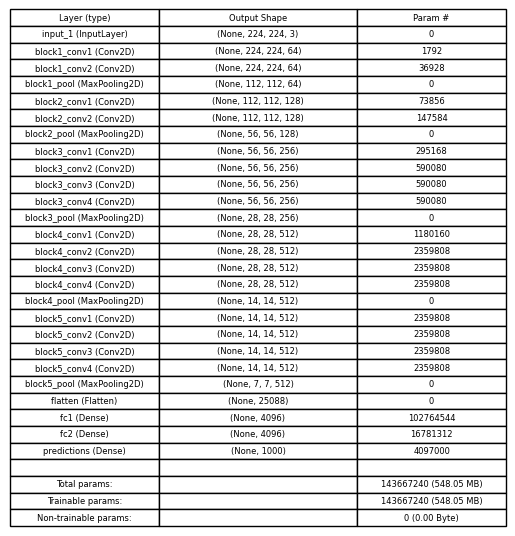

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from tabulate import tabulate

# Define the model summary as a list of tuples
model_summary = [
    ("Layer (type)", "Output Shape", "Param #"),
    ("input_1 (InputLayer)", "(None, 224, 224, 3)", "0"),
    ("block1_conv1 (Conv2D)", "(None, 224, 224, 64)", "1792"),
    ("block1_conv2 (Conv2D)", "(None, 224, 224, 64)", "36928"),
    ("block1_pool (MaxPooling2D)", "(None, 112, 112, 64)", "0"),
    ("block2_conv1 (Conv2D)", "(None, 112, 112, 128)", "73856"),
    ("block2_conv2 (Conv2D)", "(None, 112, 112, 128)", "147584"),
    ("block2_pool (MaxPooling2D)", "(None, 56, 56, 128)", "0"),
    ("block3_conv1 (Conv2D)", "(None, 56, 56, 256)", "295168"),
    ("block3_conv2 (Conv2D)", "(None, 56, 56, 256)", "590080"),
    ("block3_conv3 (Conv2D)", "(None, 56, 56, 256)", "590080"),
    ("block3_conv4 (Conv2D)", "(None, 56, 56, 256)", "590080"),
    ("block3_pool (MaxPooling2D)", "(None, 28, 28, 256)", "0"),
    ("block4_conv1 (Conv2D)", "(None, 28, 28, 512)", "1180160"),
    ("block4_conv2 (Conv2D)", "(None, 28, 28, 512)", "2359808"),
    ("block4_conv3 (Conv2D)", "(None, 28, 28, 512)", "2359808"),
    ("block4_conv4 (Conv2D)", "(None, 28, 28, 512)", "2359808"),
    ("block4_pool (MaxPooling2D)", "(None, 14, 14, 512)", "0"),
    ("block5_conv1 (Conv2D)", "(None, 14, 14, 512)", "2359808"),
    ("block5_conv2 (Conv2D)", "(None, 14, 14, 512)", "2359808"),
    ("block5_conv3 (Conv2D)", "(None, 14, 14, 512)", "2359808"),
    ("block5_conv4 (Conv2D)", "(None, 14, 14, 512)", "2359808"),
    ("block5_pool (MaxPooling2D)", "(None, 7, 7, 512)", "0"),
    ("flatten (Flatten)", "(None, 25088)", "0"),
    ("fc1 (Dense)", "(None, 4096)", "102764544"),
    ("fc2 (Dense)", "(None, 4096)", "16781312"),
    ("predictions (Dense)", "(None, 1000)", "4097000"),
    ("", "", ""),
    ("Total params:", "", "143667240 (548.05 MB)"),
    ("Trainable params:", "", "143667240 (548.05 MB)"),
    ("Non-trainable params:", "", "0 (0.00 Byte)")
]

# Create an image from the HTML table
img = Image.new('RGB', (1000, 800), color='white')
plt.axis('off')
plt.table(cellText=model_summary, loc='center', cellLoc='center', colLabels=None, colWidths=[0.3, 0.4, 0.3])
plt.savefig('vgg19_model_summary.png', bbox_inches='tight', pad_inches=0, transparent=True)

# Show the image
img.show()


In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # Force TensorFlow to use CPU only

from tensorflow.keras.models import load_model

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load the saved model

# Preprocess the test data
X_test_preprocessed = preprocess_input(X_test)

# Make predictions on the test data
y_pred = model.predict(X_test_preprocessed)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert test labels to numeric labels if needed
label_encoder = LabelEncoder()
y_test_labels = label_encoder.fit_transform(y_test)

# Calculate the metrics
accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

85/85 [==============================] - 2s 25ms/step
Accuracy: 0.9777777777777777
Precision: 0.9782408764152226
Recall: 0.9777777777777777
F1 Score: 0.9777980780159173


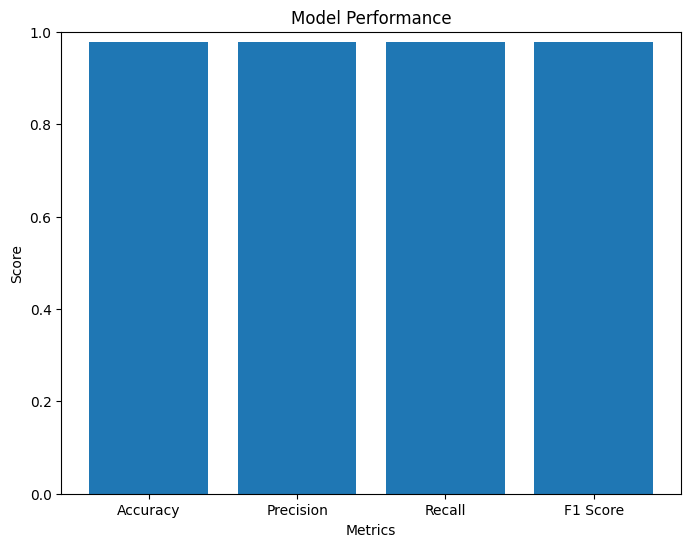

In [ ]:
import matplotlib.pyplot as plt

# Create a bar plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, scores)
plt.ylim([0, 1])
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance')

# Display the plot
plt.show()

In [ ]:
import pandas as pd

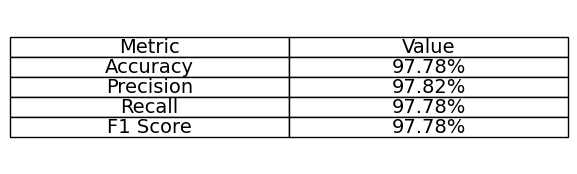

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 2))

# Remove the plot frame
ax.axis('off')

# Create the table data
data = [['Metric', 'Value'],
        ['Accuracy', '{:.2%}'.format(accuracy)],
        ['Precision', '{:.2%}'.format(precision)],
        ['Recall', '{:.2%}'.format(recall)],
        ['F1 Score', '{:.2%}'.format(f1)]]

# Create the table
table = ax.table(cellText=data, cellLoc='center', loc='center')

# Set table properties
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 1.2)

# Save the figure as an image file
plt.savefig('performance_metrics.png', dpi=300, bbox_inches='tight')

# Display the image
plt.show()

MODEL COMPARISON

SEQUENTIAL MODEL

In [ ]:
import tensorflow as tf


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/drive/MyDrive/Kaggle3/Train_Alphabet/'
test_data_dir = '/content/drive/MyDrive/Kaggle3/Test_Alphabet/'

# Initialize ImageDataGenerator for train and test data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(48, 48),
        batch_size=32,
        class_mode='categorical')

# Flow validation images in batches of 32 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(48, 48),
        batch_size=32,
        class_mode='categorical')

Found 24301 images belonging to 27 classes.
Found 2700 images belonging to 27 classes.


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/detect2.keras')



In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# calcualte F! score and precision



85/85 [==============================] - 58s 675ms/step - loss: 0.0889 - accuracy: 0.9737
Test Loss: 0.08892439305782318
Test Accuracy: 0.9737036824226379


In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
import pandas as pd

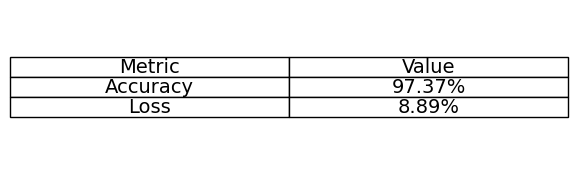

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 2))

# Remove the plot frame
ax.axis('off')

# Create the table data
data = [['Metric', 'Value'],
        ['Accuracy', '{:.2%}'.format(accuracy)],
        ['Loss', '{:.2%}'.format(loss)],
      ]

# Create the table
table = ax.table(cellText=data, cellLoc='center', loc='center')

# Set table properties
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 1.2)

# Save the figure as an image file
plt.savefig('performance_metrics.png', dpi=300, bbox_inches='tight')

# Display the image
plt.show()

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/detect2.keras')

# Preprocess the test data
# Step 3: Load and preprocess training and testing images
# X_train, y_train = load_and_preprocess_images(train_data_dir)
# X_test, y_test = load_and_preprocess_images(test_data_dir)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert test labels to numeric labels if needed
label_encoder = LabelEncoder()
y_test_labels = label_encoder.fit_transform(y_test)

# Calculate the metrics
accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

NameError: name 'X_test' is not defined

VISION TRANSFORMER

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Load pre-trained Vision Transformer model
model = torch.load('Pretrained_ViT_B_16.pth')
model.load_state_dict(torch.load('vit_model.pth'))
model.to('cuda')
model.eval()

# Define transforms to preprocess input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess input image
input_image_path = '/content/drive/MyDrive/Kaggle3/Test_Alphabet/N/089e9b3e-a837-4426-a543-f0e07f0e1033.rgb_0000.png'  # Provide path to your input image
input_image = Image.open(input_image_path)
input_tensor = transform(input_image).unsqueeze(0).to('cuda')  # Add batch dimension

# Perform inference to get model prediction
with torch.no_grad():
    output = model(input_tensor)

predicted_class = torch.argmax(output).item()
print("Predicted Class:", predicted_class)


Predicted Class: 14


In [ ]:
import torch

# Load the state dictionary from the file
state_dict = torch.load('/content/drive/MyDrive/vit_model123.pth')

# Modify the state dictionary keys to match the correct number of classes (27)
for key in list(state_dict.keys()):
    if key.startswith("heads."):
        del state_dict[key]

# Initialize the model with the correct number of classes
num_classes = 27
model = models.vit_b_16(pretrained=False, num_classes=num_classes)

# Load the modified state dictionary into the model
model.load_state_dict(state_dict, strict=False)

print("Model loaded successfully!")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully!


In [ ]:
# Load dataset
train_dir = '/content/drive/MyDrive/Kaggle3/Train_Alphabet/'
test_dir = '/content/drive/MyDrive/Kaggle3/Test_Alphabet/'

In [ ]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(train_dir:str, test_dir:str, transform:transforms.Compose, batch_size:int, num_workers:int=NUM_WORKERS):
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    class_names = train_data.classes

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_dataloader, test_dataloader, class_names

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import datasets, transforms, models

# Define paths and batch size
train_dir = '/content/drive/MyDrive/Kaggle3/Train_Alphabet/'
test_dir = '/content/drive/MyDrive/Kaggle3/Test_Alphabet/'

batch_size = 32

# Set up data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create the datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the device to use (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model (assuming the model architecture is correct and loaded as shown in your code)
num_classes = 27
model = models.vit_b_16(pretrained=False, num_classes=num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/vit_model123.pth'), strict=False)
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Function to calculate accuracy
def calculate_accuracy(y_true, y_pred):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).sum().item()
    return correct

# Evaluate the model
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for batch in dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update total loss
            total_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            total_correct += calculate_accuracy(labels, outputs)
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    avg_accuracy = total_correct / total_samples

    return avg_loss, avg_accuracy

# Calculate accuracy and loss for the test set
test_loss, test_accuracy = evaluate_model(model, test_dataloader, criterion)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Loss: 3.2958
Test Accuracy: 0.0370


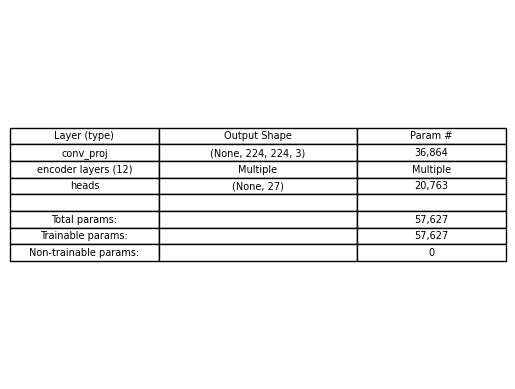

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Define the model summary as a list of tuples
model_summary = [
    ("Layer (type)", "Output Shape", "Param #"),
    ("conv_proj", "(None, 224, 224, 3)", "36,864"),
    ("encoder layers (12)", "Multiple", "Multiple"),
    ("heads", "(None, 27)", "20,763"),
    ("", "", ""),
    ("Total params:", "", "57,627"),
    ("Trainable params:", "", "57,627"),
    ("Non-trainable params:", "", "0")
]

# Create an image from the table
img = Image.new('RGB', (600, 300), color='white')
plt.axis('off')
plt.table(cellText=model_summary, loc='center', cellLoc='center', colLabels=None, colWidths=[0.3, 0.4, 0.3])
plt.savefig('vision_transformer_summary.png', bbox_inches='tight', pad_inches=0, transparent=True)

# Show the image
img.show()
